<div style="text-align: justify; text-justify: inter-word;">

# Smart Grid Stability Prediction

The emergence of new renewable energy sources is rapidly transforming the structure of electrical grid distribution. Historically, the energy sector heavily relied on a small number of producers, primarily focused on fossil fuels, who supplied energy in a one-way fashion to consumers. However, the current landscape has witnessed a significant shift. Now, both households and businesses not only consume energy but also have the ability to generate and sell it. This is often achieved through the installation of solar panels on rooftops or within property gardens, for instance. This transformative development has resulted in a bidirectional flow of energy within the grid, introducing a more intricate challenge in managing the balance of supply and demand.

Within these so-called 'smart grids,' the primary goal is to comprehensively assess and proactively manage disruptions and fluctuations in energy production and consumption introduced by all the participants within the system. This approach relies not only on technical considerations but also on the way in which participants adapt to variations in energy prices.

Researchers in this field are primarily focused on Decentral Smart Grid Control (DSGC) systems. This methodology hinges on monitoring the electrical grid frequency (AC frequency) to gauge the current network power balance, enabling the derivation of an appropriate energy price.

The mathematical model for DSGC is designed to pinpoint grid instability within a reference 4-node star architecture, consisting of one supply source and three consumption nodes. The model takes into account several key features:

1. Total power balance, which includes the nominal power produced or consumed at each grid node.
2. The response time of participants to adjust their consumption and/or production in reaction to price changes.
3. Energy price elasticity.

### Problematic

As with all complex mathematical models based on differential equations, certain assumptions and simplifications are necessary to solve them. However, these simplifications can lead to challenges when it comes to accurately determining grid stability. (For more details on these issues, you can refer to the dataset papers.)

And so our objective now is to use machine/deep learning models and the nodes' data to approximate the DSGC mathematical model and learn how to make accurate grid stability predictions based on these given features.

</div>


## About the Dataset

The original dataset used in this study (can be found [here](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data)) contains 10,000 observations from simulations of grid stability for a reference 4-node star network, the data is composed of the following fields :

* 'tau1' to 'tau4': the reaction time of each network participant, which ranges between 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
* 'p1' to 'p4': nominal power produced by supplier node ('p1' which is positive) or power consumed by each network participant ('p2' to 'p4'), ranging from -2.0 to -0.5 for consumers. (total power consumed equals total power generated => p1 = - (p2 + p3 + p4));
* 'g1' to 'g4': price elasticity coefficient ('gamma') for each network participant, ranging 0.05 to 1.00 ('g1' for the supplier node, 'g2' to 'g4' for the consumer nodes);
* 'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative it's linearly stable);
* 'stabf': a categorical label ('stable' or 'unstable') derived from 'stab' value.

Due the symetricity of the data, it can be augmented into up to 60,000 observations (as the three consumer nodes can be interchanged) which results in the used [kaggle dataset](https://www.kaggle.com/datasets/pcbreviglieri/smart-grid-stability).

As the 'stabf' field is directly derived from the 'stab' value ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), and because we are considering a classification problem here we will keep the 'stabf' variable as our target and drop the 'stab' field.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
data = pd.read_csv("./smart_grid_stability_augmented.csv")

In [4]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [5]:
data.shape

(60000, 14)

In [6]:
data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


In [7]:
# Check if target classes are balanced
data["stabf"].value_counts(normalize=True)

stabf
unstable    0.638
stable      0.362
Name: proportion, dtype: float64

In [8]:
# Data does not contain any missing values
data.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [9]:
# all the fields are of type float except for "stabf"
data.dtypes

tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

## Exploratory Data Analysis

In [55]:
# Encode the "stabf" variable classes
data["stabf"] = data["stabf"].map({"stable": 0, "unstable": 1})

In [56]:
df = data.copy()
target = data["stabf"]
features = data.drop(["stabf", "stab"], axis=1)

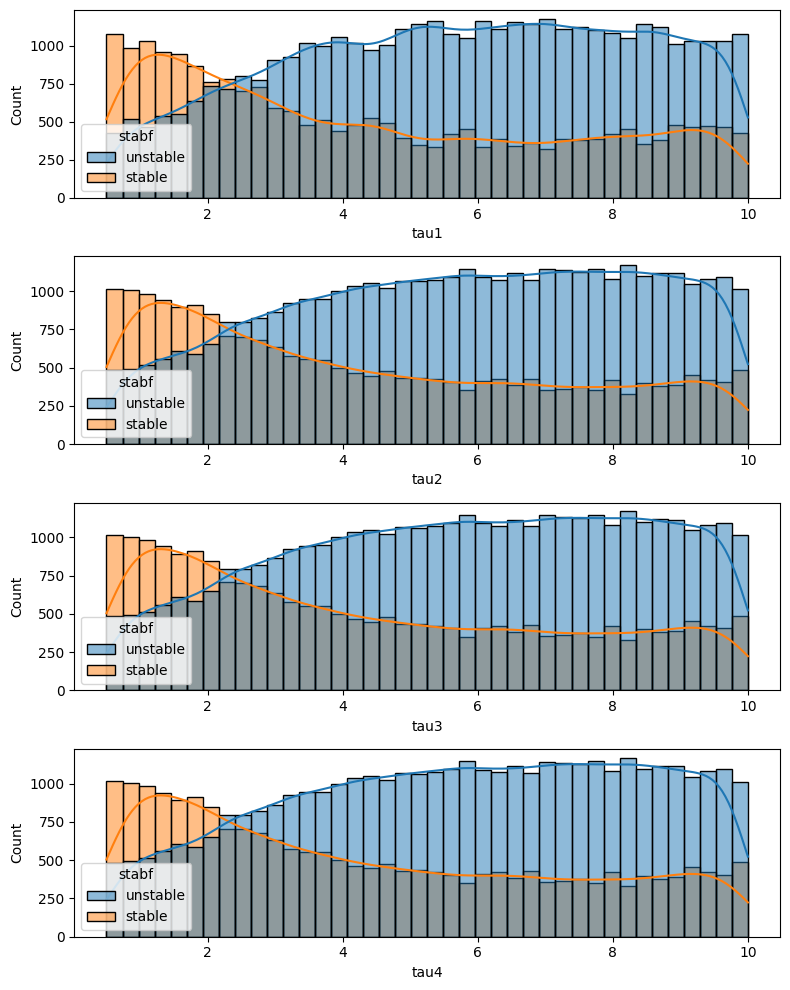

In [49]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

sns.histplot(data=data, x="tau1", hue='stabf', kde=True, ax=axes[0])
sns.histplot(data=data, x="tau2", hue='stabf', kde=True, ax=axes[1])
sns.histplot(data=data, x="tau3", hue='stabf', kde=True, ax=axes[2])
sns.histplot(data=data, x="tau4", hue='stabf', kde=True, ax=axes[3])

plt.tight_layout()
plt.show()

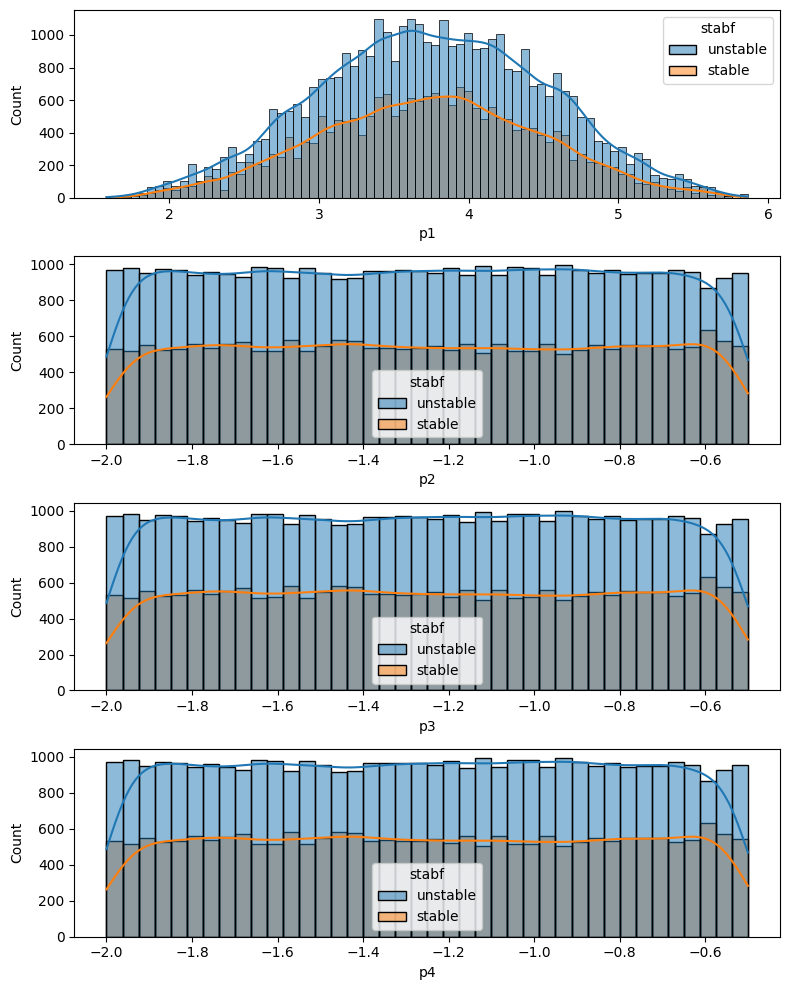

In [50]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

sns.histplot(data=data, x="p1", hue='stabf', kde=True, ax=axes[0])
sns.histplot(data=data, x="p2", hue='stabf', kde=True, ax=axes[1])
sns.histplot(data=data, x="p3", hue='stabf', kde=True, ax=axes[2])
sns.histplot(data=data, x="p4", hue='stabf', kde=True, ax=axes[3])

plt.tight_layout()
plt.show()

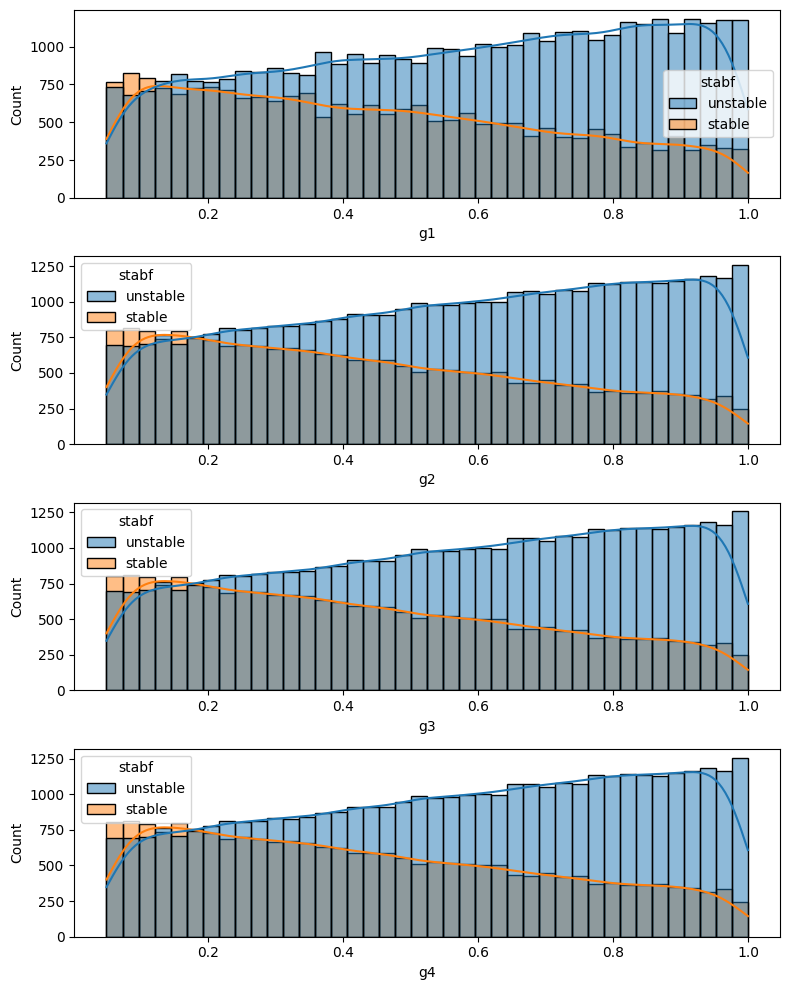

In [51]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

sns.histplot(data=data, x="g1", hue='stabf', kde=True, ax=axes[0])
sns.histplot(data=data, x="g2", hue='stabf', kde=True, ax=axes[1])
sns.histplot(data=data, x="g3", hue='stabf', kde=True, ax=axes[2])
sns.histplot(data=data, x="g4", hue='stabf', kde=True, ax=axes[3])

plt.tight_layout()
plt.show()

What those distribution plots tell us ? 

<Axes: >

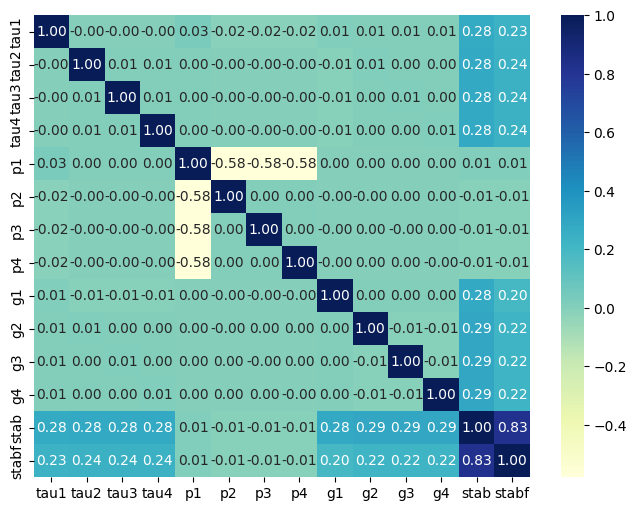

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), cmap='YlGnBu', fmt='.2f', annot=True)

We can see that :

1. As expected the 'stab' and 'stabf' fileds are highly correlated (as the later is derived from the former).
2. The reaction time ("tau" values) and price elasticity ("g" values) seems to have a small corrolation with the target 'stabf'.
3. The power produced/consumed ("p" values) doesn't present in relation with 'stabf'.

## Data Preprocessing

In [59]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [60]:
from sklearn.preprocessing import StandardScaler

def scale_features(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train =  scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test

In [61]:
x_train, x_test = scale_features(x_train, x_test)

## Models Training

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def accuracy_logs(y_test, y_pred):
    print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")
    print("Metrics table:\n", classification_report(y_test, y_pred, target_names=["stable", "unstable"])) 

def draw_confusion_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, index=['unstable', 'stable'], columns=['unstable', 'stable'])
    plot = sns.heatmap(matrix, cmap='YlGnBu', fmt='.2f', annot=True)
    plot.set_xlabel('predicted')
    plot.set_ylabel('real')

### Logistic Regression

In [64]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [65]:
accuracy_logs(y_test, y_pred)

accuracy_score: 0.8131666666666667
Metrics table:
               precision    recall  f1-score   support

      stable       0.76      0.71      0.73      4291
    unstable       0.84      0.87      0.86      7709

    accuracy                           0.81     12000
   macro avg       0.80      0.79      0.79     12000
weighted avg       0.81      0.81      0.81     12000



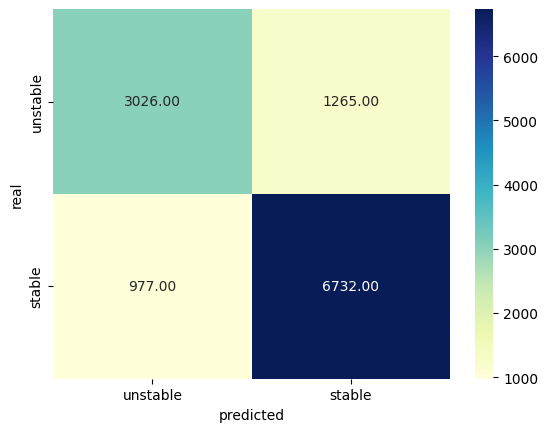

In [66]:
draw_confusion_matrix(y_test, y_pred)

### Random Forest Classifier

In [67]:
rf_Cla = RandomForestClassifier()
rf_Cla.fit(x_train, y_train)
y_pred = rf_Cla.predict(x_test)

In [68]:
accuracy_logs(y_test, y_pred)

accuracy_score: 0.95025
Metrics table:
               precision    recall  f1-score   support

      stable       0.94      0.92      0.93      4291
    unstable       0.95      0.97      0.96      7709

    accuracy                           0.95     12000
   macro avg       0.95      0.94      0.95     12000
weighted avg       0.95      0.95      0.95     12000



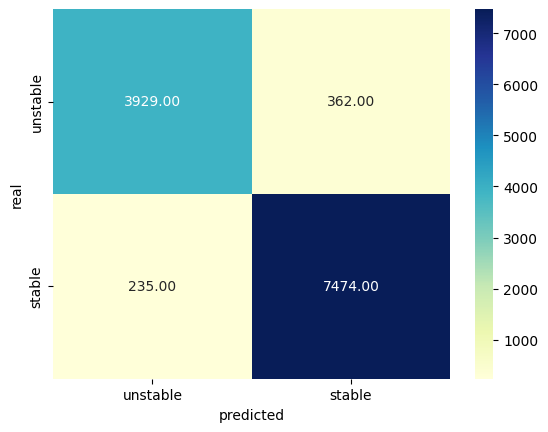

In [69]:
draw_confusion_matrix(y_test, y_pred)

### XGBoost Classifier

In [70]:
xgb_Cla = XGBClassifier()
xgb_Cla.fit(x_train, y_train)
y_pred = xgb_Cla.predict(x_test)

In [71]:
accuracy_logs(y_test, y_pred)

accuracy_score: 0.97725
Metrics table:
               precision    recall  f1-score   support

      stable       0.98      0.96      0.97      4291
    unstable       0.98      0.99      0.98      7709

    accuracy                           0.98     12000
   macro avg       0.98      0.97      0.98     12000
weighted avg       0.98      0.98      0.98     12000



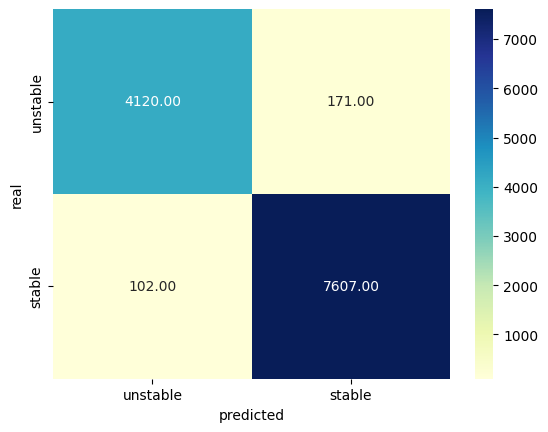

In [72]:
draw_confusion_matrix(y_test, y_pred)

### Support Vector Machine

In [73]:
svc_Cla = SVC()
svc_Cla.fit(x_train, y_train)
y_pred = svc_Cla.predict(x_test)

In [74]:
accuracy_logs(y_test, y_pred)

accuracy_score: 0.9786666666666667
Metrics table:
               precision    recall  f1-score   support

      stable       0.98      0.96      0.97      4291
    unstable       0.98      0.99      0.98      7709

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



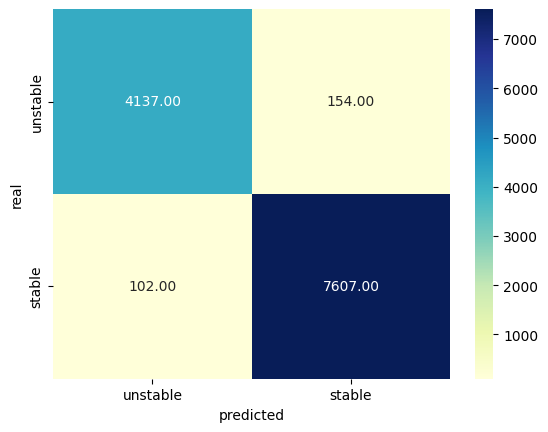

In [75]:
draw_confusion_matrix(y_test, y_pred)

## Models Hyperparameters Tuning

### 1- Random Forest Classifier

In [34]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = { 
    'n_estimators': [50, 100, 150, 200], # number of trees in the random forest
    'max_features': ['log2', 'sqrt'], # number of features in consideration at every split
    'max_depth': [int(x) for x in np.linspace(10, 120, num=12)], # maximum number of levels allowed in each decision tree
    'min_samples_split': [2, 6, 10], # minimum sample number to split a node
    'min_samples_leaf': [1, 3, 4] # minimum sample number that can be stored in a leaf node
}

rf_random = RandomizedSearchCV(estimator=rf_Cla, param_distributions=random_grid, n_iter=50, cv=5, verbose=2, random_state=0, n_jobs=-1)

In [35]:
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
135 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pa

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=0, verbose=2)

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=  47.3s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  42.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=60, max_features=auto, 

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=  47.3s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  42.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  43.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=150; total time=  42.0s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=  13.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=  45.2s
[CV] END max_depth=50, max_features=auto

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=  46.9s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  41.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, mi

In [39]:
print("Best Parameters:\n", rf_random.best_params_)
print("Score with best Parameters: ", rf_random.best_score_)

Best Parameters:
 {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90}
Score with best Parameters:  0.9474259259259259


In [38]:
y_pred = rf_random.predict(x_test)
accuracy_logs(y_test, y_pred)

accuracy_score: 0.9508333333333333
Metrics table:
               precision    recall  f1-score   support

      stable       0.95      0.91      0.93      2164
    unstable       0.95      0.97      0.96      3836

    accuracy                           0.95      6000
   macro avg       0.95      0.94      0.95      6000
weighted avg       0.95      0.95      0.95      6000



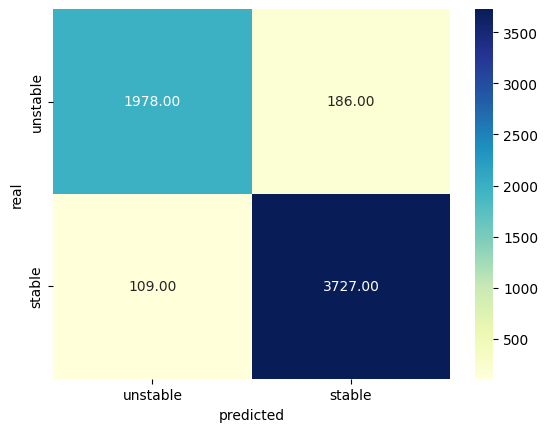

In [40]:
draw_confusion_matrix(y_test, y_pred)